In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib.pylab as pylab
import warnings
warnings.filterwarnings('ignore')
#pylab.rcParams['figure.figsize'] = 20, 18

In [2]:
train = pd.read_csv("train.csv")
train = train.ix[:, 1:]

**loss** spans orders of magnitude, and is severely right-skewed because of excessively large outliers

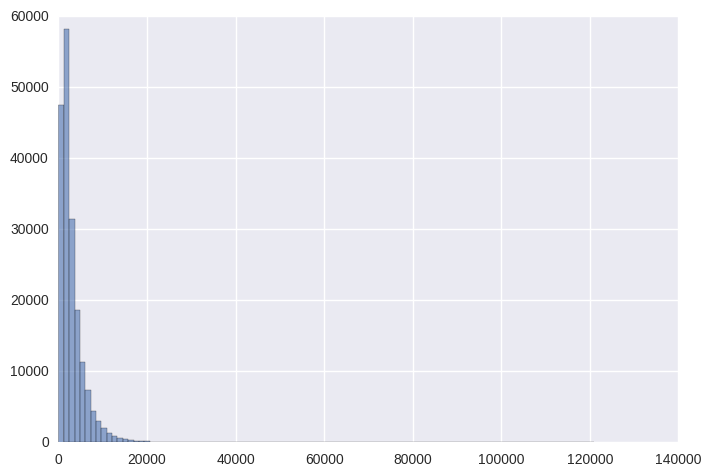

In [3]:
plt.hist(train.ix[:, -1], bins=100, alpha=0.6)
plt.show()

log-transformation mitigates the skewness, and results in a bell-shape distribution and smaller dynamic range:

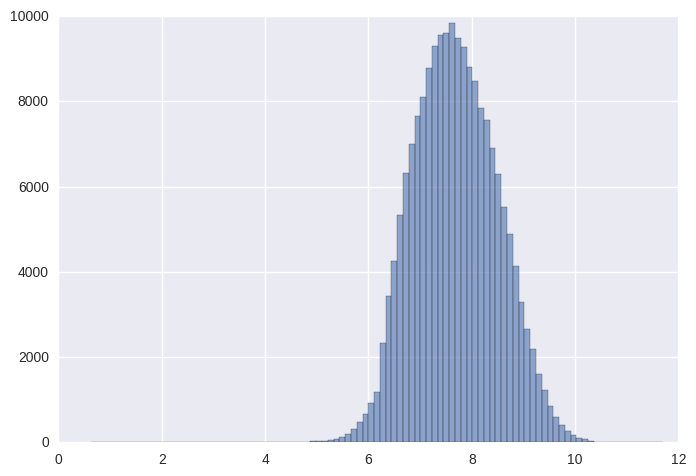

In [4]:
plt.hist(np.log1p(train.ix[:, -1]), bins=100, alpha=0.6)
plt.show()

## Categorical Features

### Correlation between each categorical feature and the target

For each categorical feature, compute the groupwise statistics (mean, std, count)

In [5]:
# groupwise statistics of "cat1"
mean = train["loss"].groupby(train["cat1"]).mean()
std = train["loss"].groupby(train["cat1"]).std()
count = train["loss"].groupby(train["cat1"]).count()
df = pd.concat([mean, std, count], axis=1)
df.columns = ["mean", "std", "count"]
df

,mean,std,count
cat1,,,
A,3408.091515,3122.436629,141550
B,1915.198521,1666.082337,46768


**cat1 - cat72**

In [6]:
""""
cat1" - "cat72" each contains two unique values ("A" and "B")
Compute the group mean (ma, mb) for "A" and "B"
Compute the ratio max(ma, mb) / min(ma, mb)
"""

a = pd.DataFrame()
for i in range(72):
    a = pd.concat([a, train["loss"].groupby(train.ix[:, i]).mean()], axis=1)
    
a = a.T    
ratio = a.max(axis=1) / a.min(axis=1)
ratio = ratio.sort_values()
pd.set_option('display.max_rows', 10)
ratio

loss    1.028444
loss    1.028775
loss    1.032509
loss    1.053370
loss    1.072469
          ...   
loss    2.022851
loss    2.038440
loss    2.306061
loss    2.817200
loss    3.506995
dtype: float64

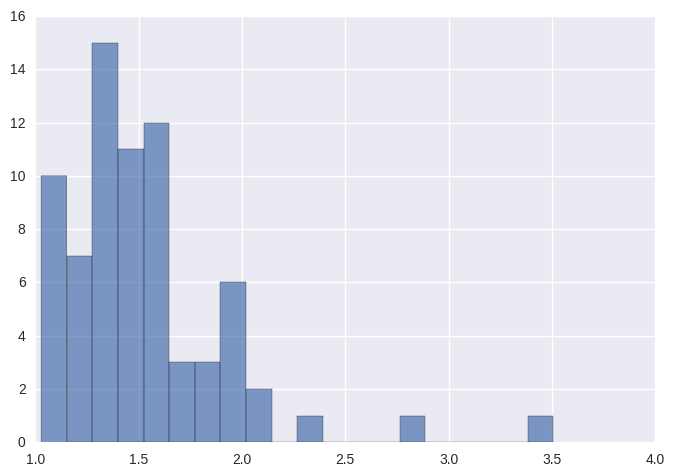

In [7]:
# Majority of the ratios are < 1.5, these features are not very informative for predicting loss on their own...

plt.hist(ratio.values, bins=20, alpha=0.7)
plt.show()

**cat73 - cat116**

Plot the group mean for cat73 - cat116, and sort them by the computed group means

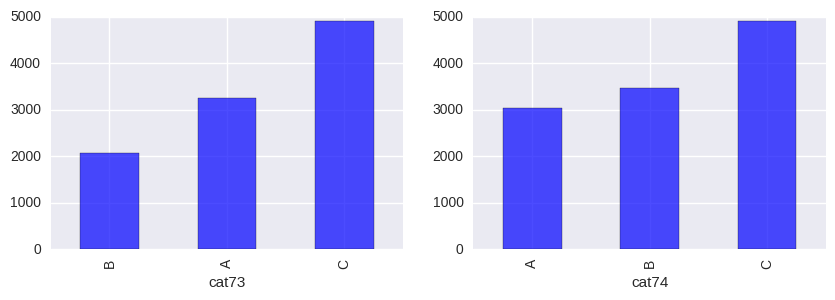

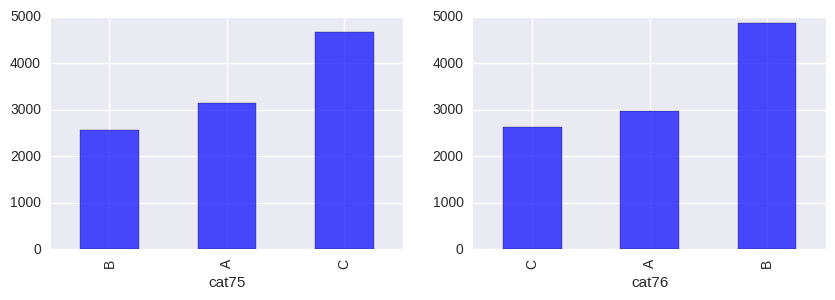

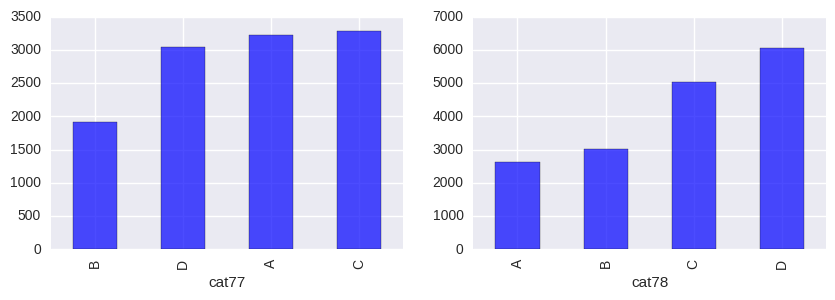

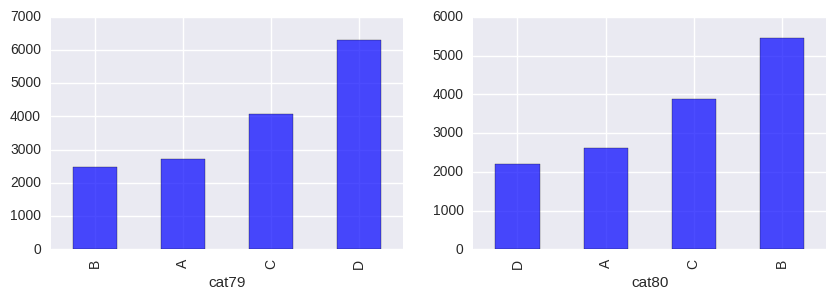

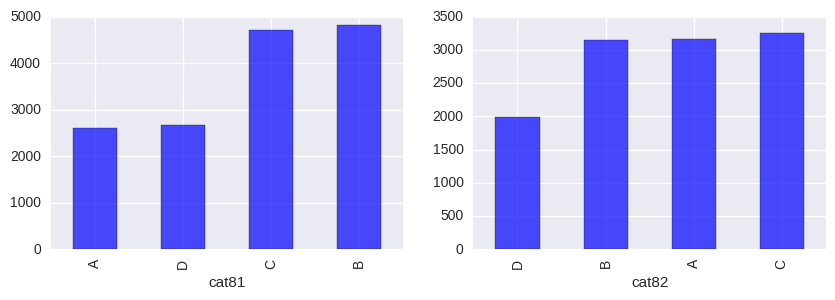

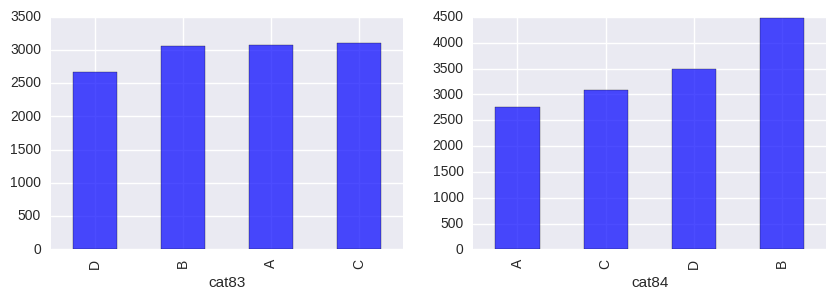

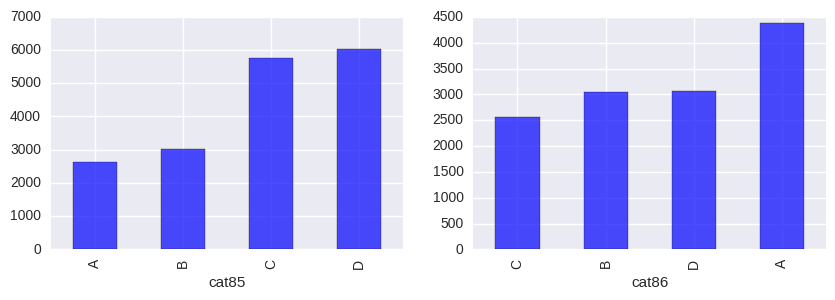

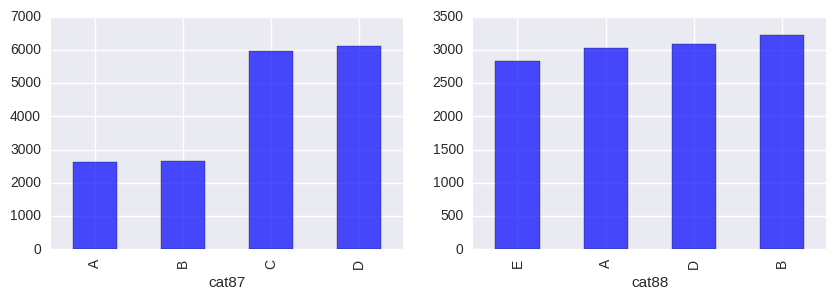

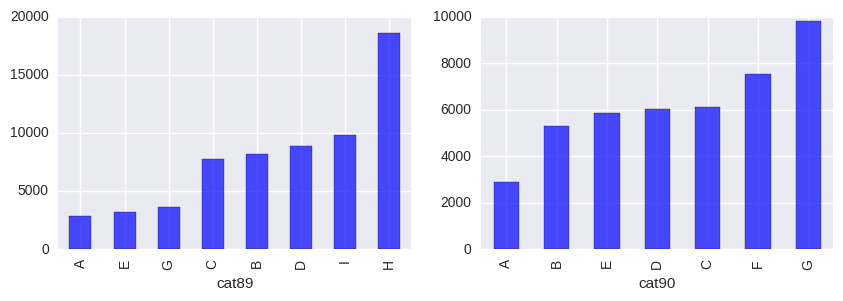

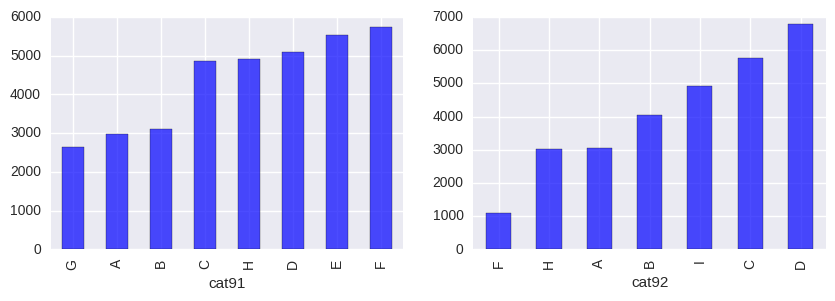

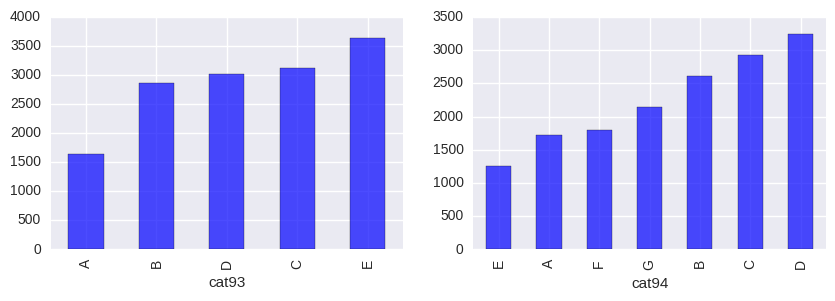

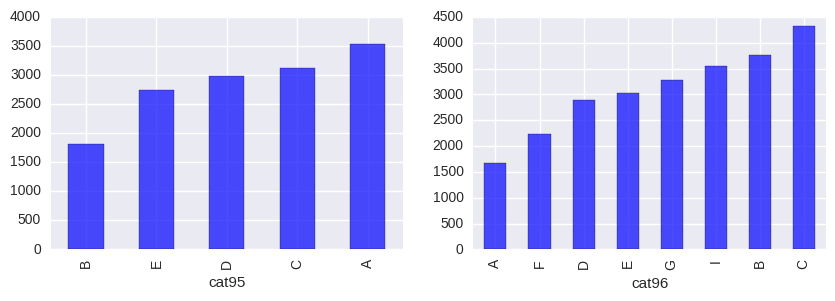

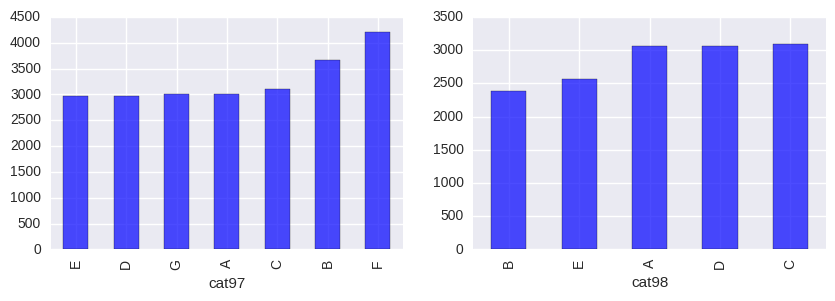

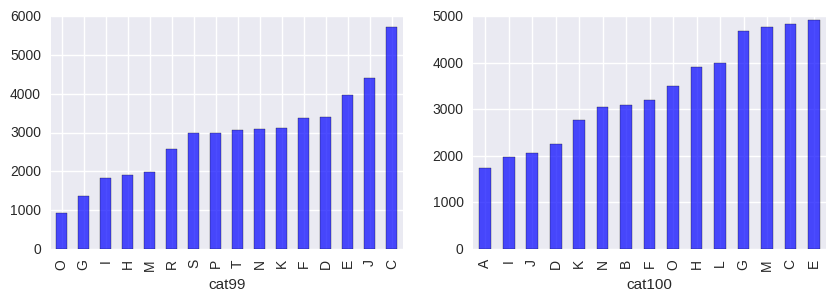

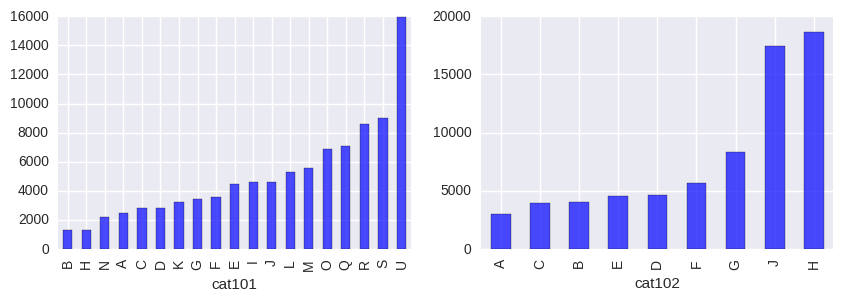

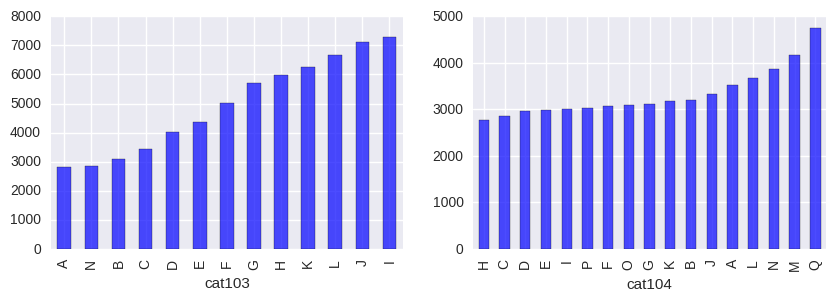

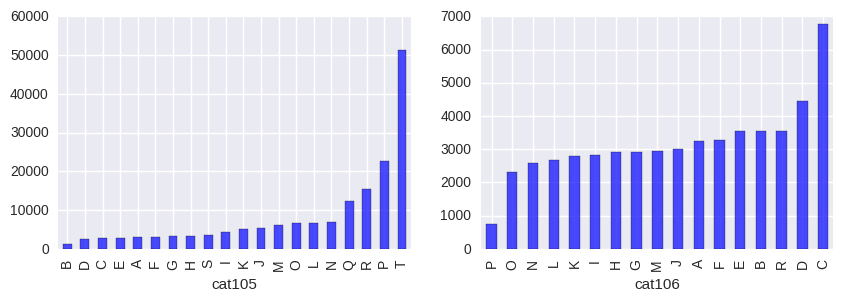

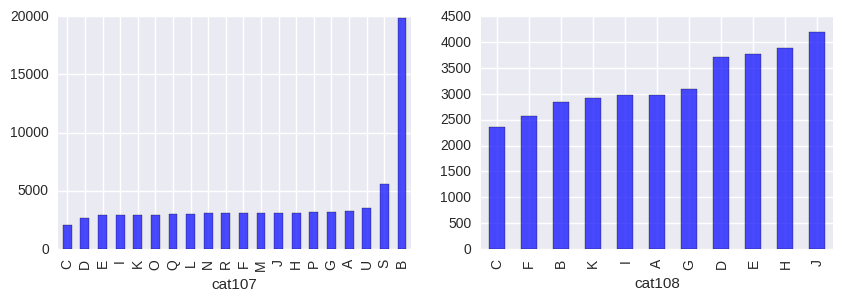

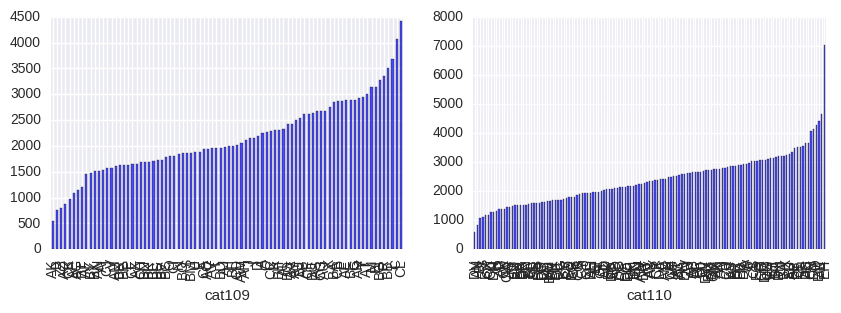

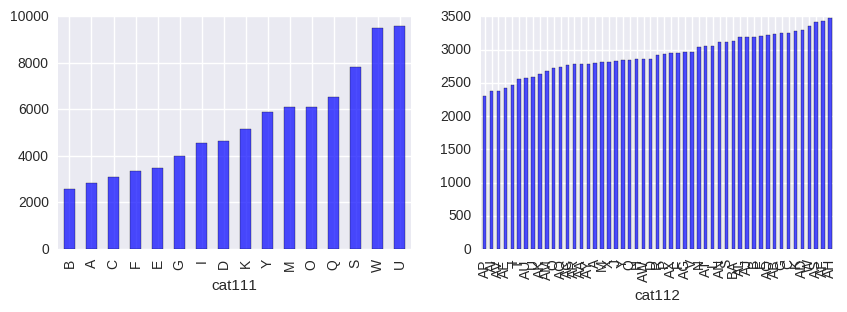

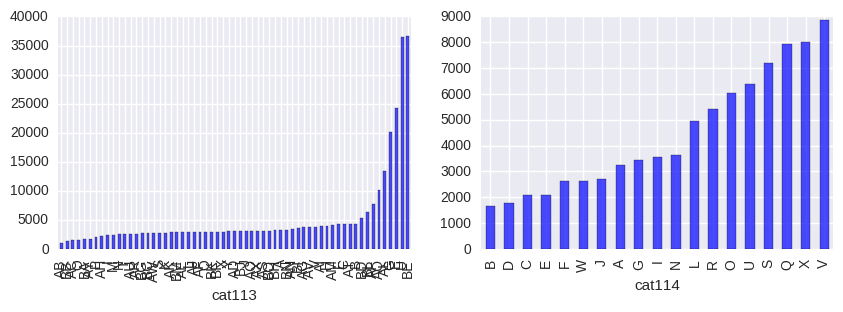

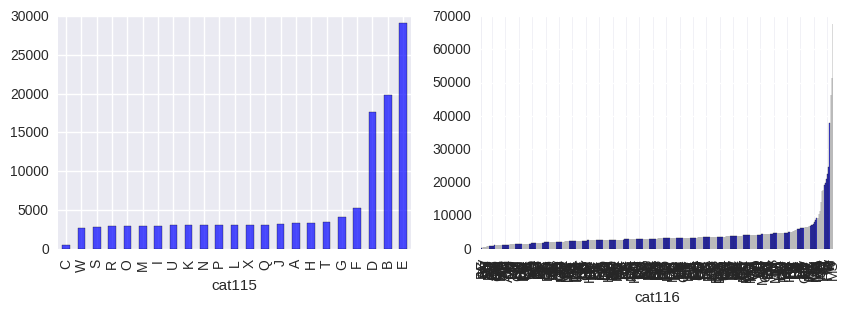

In [8]:
# x axis: group labels
# y axis: group means
index = iter(range(72, 116))   
for i in range(22):
    pylab.rcParams['figure.figsize'] = 10, 3
    fig, ax = plt.subplots(nrows=1, ncols=2)
    for j in range(2):
        mean = train["loss"].groupby(train.ix[:, next(index)]).mean()
        mean = mean.sort_values()
        mean.plot(kind="bar", color="b", alpha=0.7, ax=ax[j])
    
plt.show()

### Correlation between categorical features

In [9]:
from scipy.stats import chi2_contingency

pval = pd.DataFrame(-np.ones((116, 116)),
                    index=["cat" + str(i) for i in range(1, 117)],
                    columns=["cat" + str(j) for j in range(1, 117)])

In [10]:
for i in range(1, 117):
    for j in range(1, 117):
        if i != j:
            contingency = pd.crosstab(train["cat" + str(i)], train["cat" + str(j)])
            statistic, pv, ddof, expected = chi2_contingency(contingency)
            pval.ix["cat" + str(i), "cat" + str(j)] = pv

In [11]:
contingency

cat115,A,B,C,D,E,F,G,H,I,J,...,N,O,P,Q,R,S,T,U,W,X
cat116,,,,,,,,,,,,,,,,,,,,,
AA,0,0,0,0,0,0,0,2,1,1,...,0,0,0,0,0,0,0,0,0,0
AB,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
AC,0,0,0,0,0,0,0,0,85,0,...,0,0,0,0,0,0,0,0,0,0
AD,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
AE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U,0,0,0,0,0,0,0,8,0,6,...,0,0,0,0,0,0,0,0,0,0
V,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The contingency table is created using **pd.crosstab** for each pair of categorical features, and the p-value for chi-squared test is computed.

The following heatmap shows the p-values. The darker the color, the larger the p-value, meaning the corresponding pair of categorical variables are not likely to be correlated

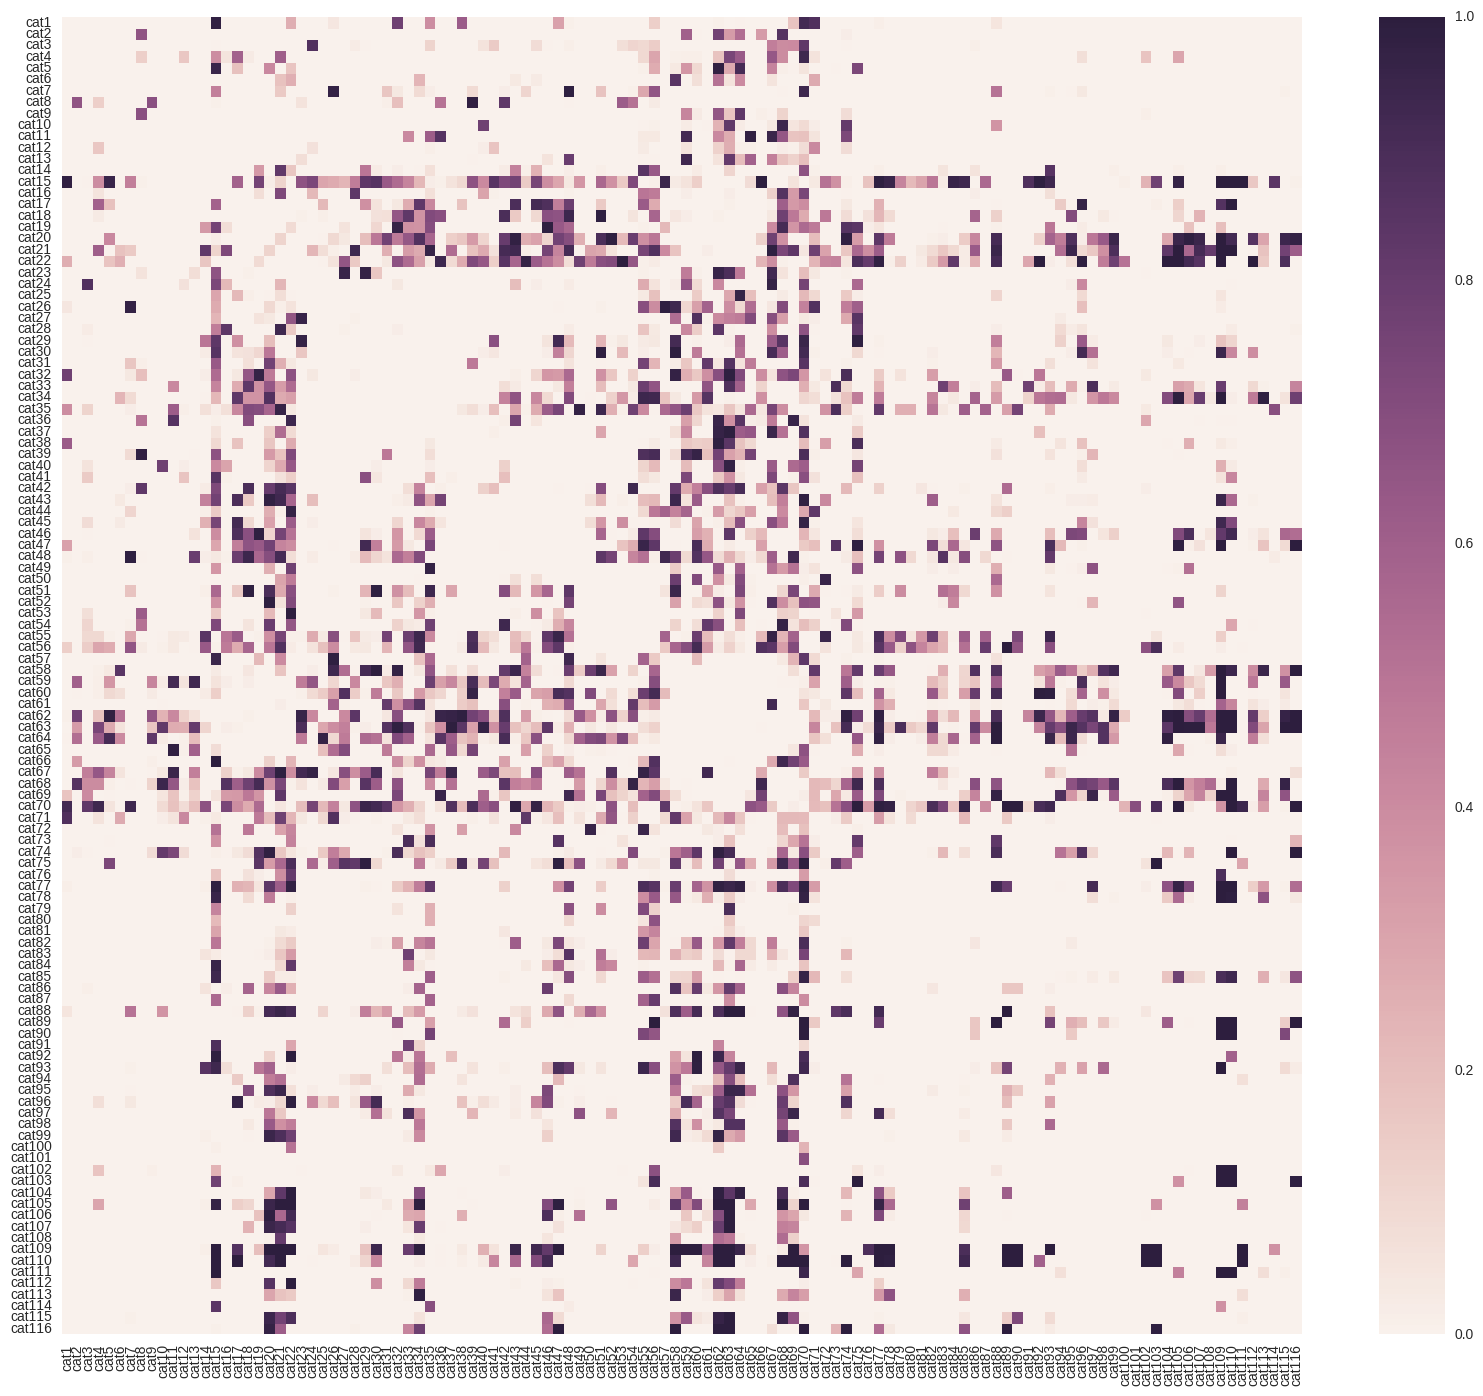

In [12]:
import seaborn as sns
pylab.rcParams['figure.figsize'] = 20, 17
sns.heatmap(pval, vmin=0., vmax=1.)
plt.show()

There appears to be two horizontal dark **stripes** (row "cat15" - "cat22" and "cat55" - "cat71") that spans almost across all the columns: these cat features are not correlated any other cat features. Are they redundant and the removal of them would improve predictive modelling?

## Continous Features

**cont1 - cont14**

First plot the histogram of continous features

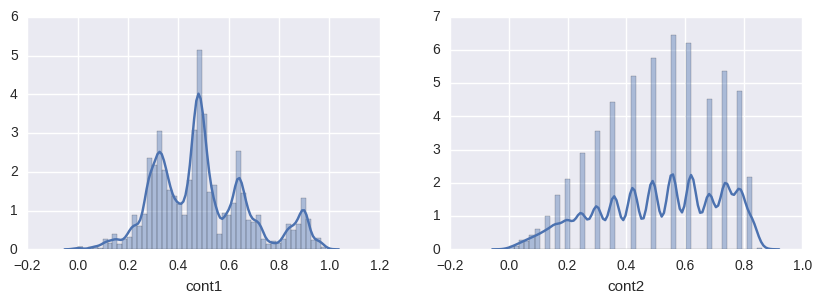

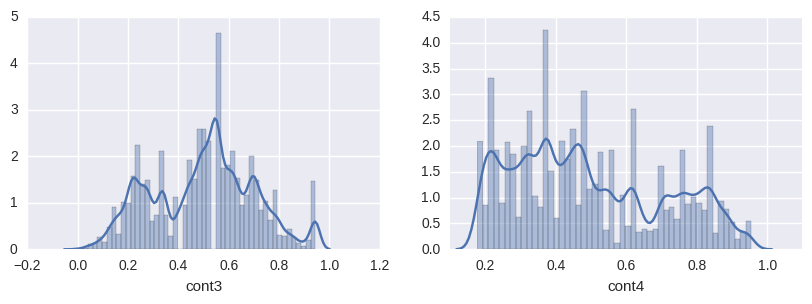

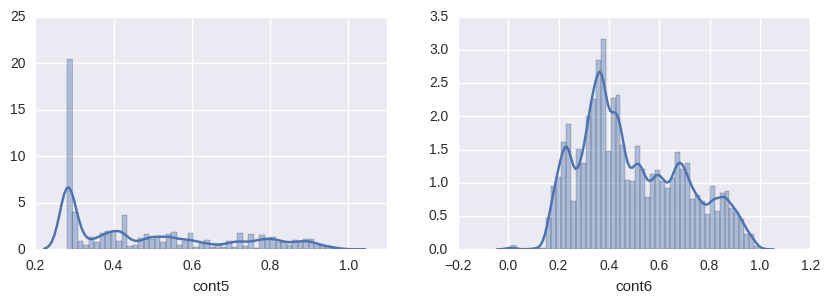

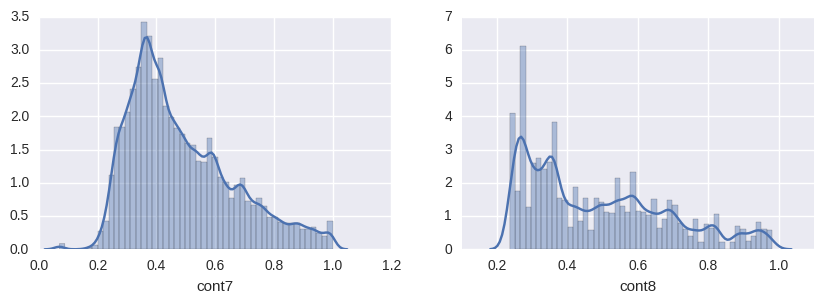

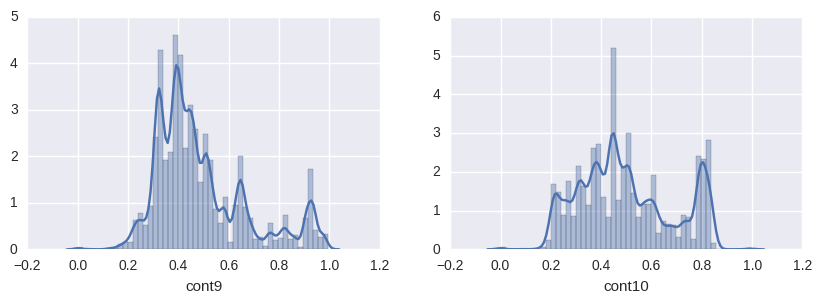

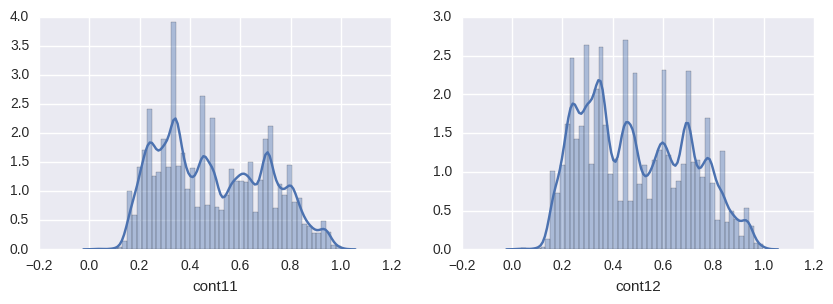

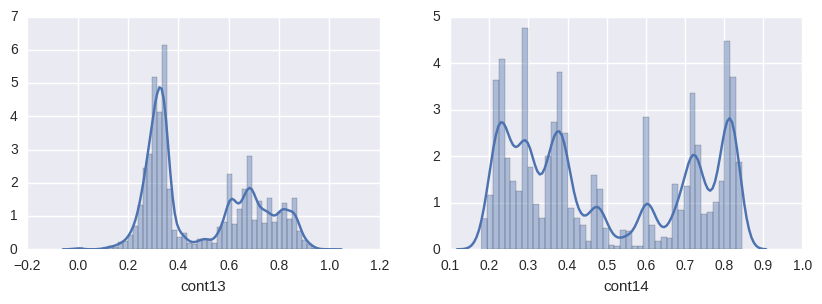

In [13]:
index = iter(range(116, 131))   
for i in range(7):
    pylab.rcParams['figure.figsize'] = 10, 3
    fig, ax = plt.subplots(nrows=1, ncols=2)
    for j in range(2):
        which = next(index)
        sns.distplot(train.ix[:, which], ax=ax[j])
        
plt.show()        

**Observation:** cont2 looks more like a categorical feature rather than continous feature

#### Correlation between continous features and target

Rather than doing scatter plots between each continous variable and the target, we discretize each continous feature into equal-sized groups, and compute the group means of target as if they were categorical variables:

Some features seem to be linearly correlated with loss (e.g. cont2, cont3, cont7, cont11, cont12)

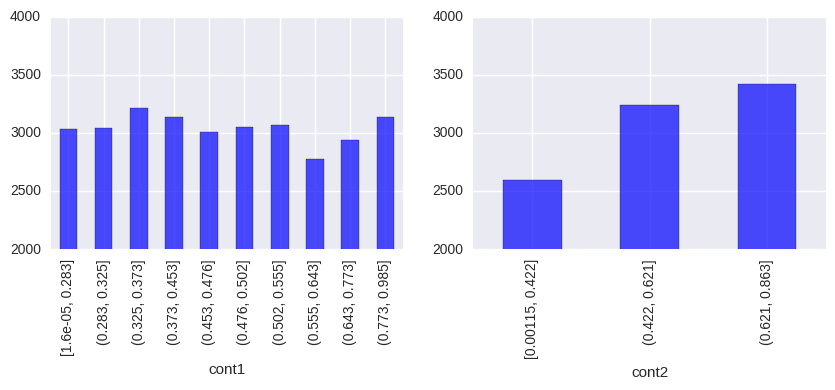

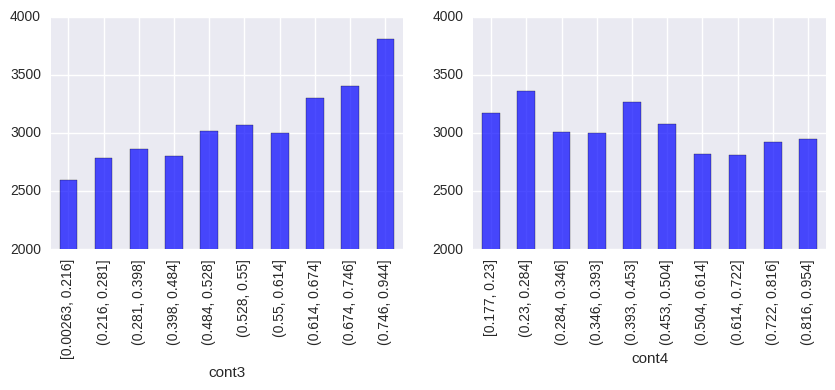

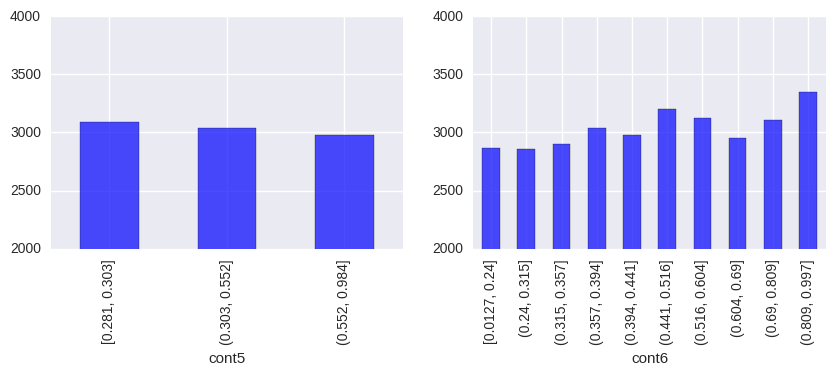

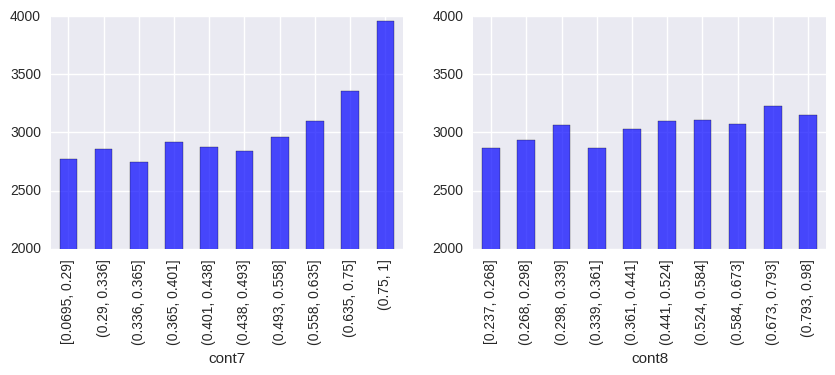

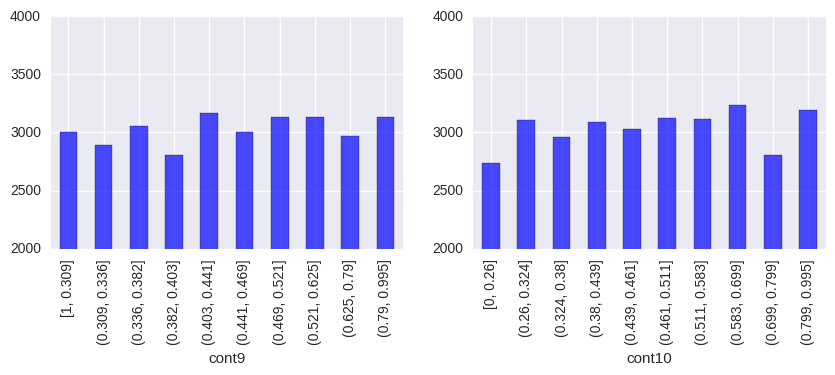

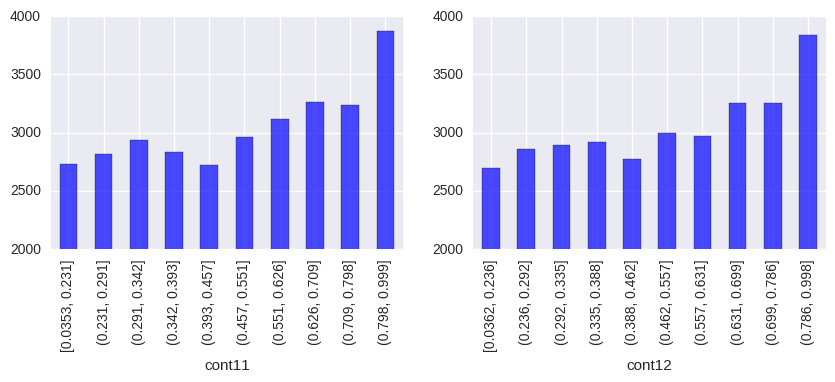

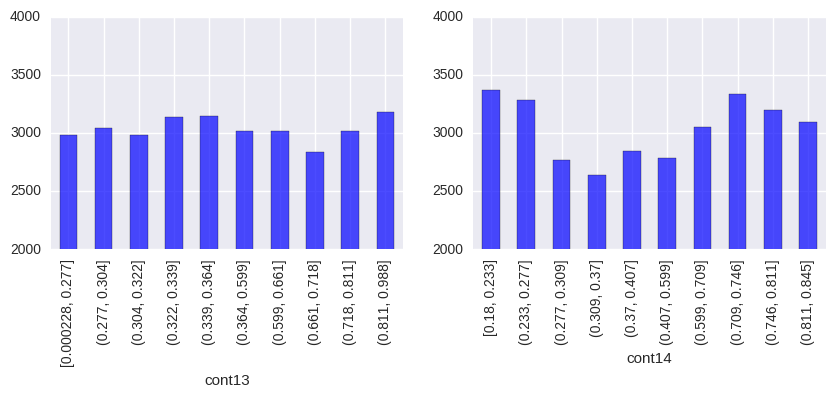

In [14]:
index = iter(range(116, 131))   
for i in range(7):
    pylab.rcParams['figure.figsize'] = 10, 3
    fig, ax = plt.subplots(nrows=1, ncols=2)
    for j in range(2):
        which = next(index)
        try:
            factor = pd.qcut(train.ix[:, which], 10)
        except ValueError:
            # fewer bins
            factor = pd.qcut(train.ix[:, which], 3)
        mean = train["loss"].groupby(factor).mean()
        mean.plot(kind="bar", color="b", alpha=0.7, ax=ax[j], ylim=[2000, 4000])

plt.show()

### Correlation between continous features

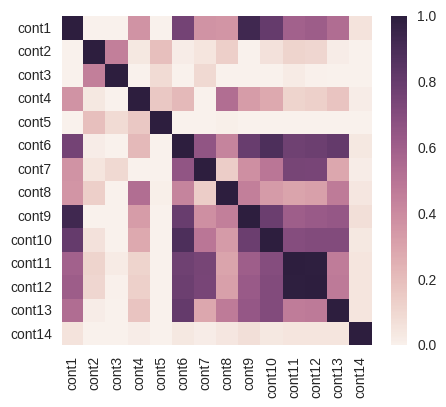

In [18]:
pylab.rcParams['figure.figsize'] = 5, 4.25
corr = train.ix[:, "cont1":"cont14"].corr()
sns.heatmap(corr, vmin=0., vmax=1.)
plt.show()

cont6 - cont13 seems to form a "clique": highly correlated with each other

cont14 seems not to be correlated with any other feature

Feautres that are highly correlated cont1 ~ cont9, cont11 ~ cont12

In [16]:
threshold = 0.9
corr[corr<threshold] = 0.
corr[corr>=threshold] = 1.

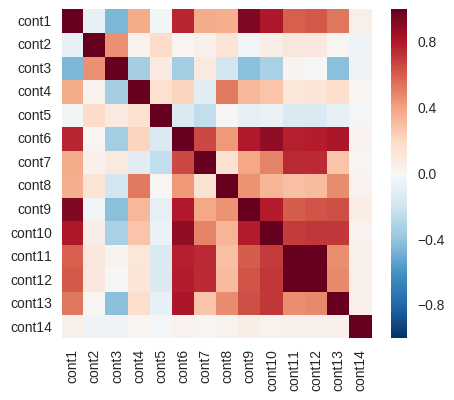

In [19]:
pylab.rcParams['figure.figsize'] = 5, 4.25
sns.heatmap(corr, vmin=0., vmax=1.)
plt.show()

# The observations for EDA

The features are pretty heterogenous, some features are correlated with each other, some features are not correlated with the target. cat110 and cat116 contans way too many unique values to be transformed by one-hot encoding. We need to do some feature engineering/massaging.